<a href="https://colab.research.google.com/github/harin/cudsi-capstone-2019/blob/master/embedding/transfer_learning_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install spacy==2.2 spacy-transformers
!python -m spacy download en_trf_bertbaseuncased_lg

  Using cached https://files.pythonhosted.org/packages/1c/96/10881bc82d05664c40a38cf7c645e6ab1877e5808ef4a3684a99cd1445a4/spacy-2.2.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/4c/60/cbe7c1ca0d05e9861375fc9fe73f5c6828666bb994e193a80bce554c4004/thinc-7.1.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: spacy-transformers 0.5.1 has requirement spacy<2.3.0,>=2.2.1, but you'll have spacy 2.2.0 which is incompatible.
ERROR: en-trf-bertbaseuncased-lg 2.2.0 has requirement spacy>=2.2.1, but you'll have spacy 2.2.0 which is incompatible.
  Found existing installation: thinc 7.3.1
    Uninstalling thinc-7.3.1:
      Successfully uninstalled thinc-7.3.1
  Found existing installation: spacy 2.2.3
    Uninstalling spacy-2.2.3:
      Successfully uninstalled spacy-2.2.3
     |████████████████████████████████| 10.4MB 8.8MB/s 
     |████████████████████████████████| 2.2MB 55.1MB/s 
  Found existing installation: thinc 7.1.1
    Uninstalling thinc-7.1.1:
      Suc

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import random
from spacy.util import minibatch

In [5]:
import spacy
import torch

is_using_gpu = spacy.prefer_gpu()
if is_using_gpu:
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

nlp = spacy.load("en_trf_bertbaseuncased_lg")

In [6]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
STOPWORDS = set(stopwords.words('english'))

def clean_text_lemma(text):
    """
        text: a paragrapy
        
        return: modified initial string
    """
    text = re.sub(r"[^\w\s]", '', text) ## Remove all non-word characters (everything except numbers and letters)
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    text_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in text_list]) # lemmatization
    #text_list2 = nltk.word_tokenize(lemmatized_output)
    #stemmed_output = ' '.join([porter.stem(w) for w in text_list2]) #stemming
    return lemmatized_output

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
!ls "/content/gdrive/Shared drives/Columbia/Article Categorization/"


 data_USAevents_2019_09_04_13_58_10.csv
'Results Codebook.gdoc'
 results_USAevents_2019_09_04_13_58_10.csv


In [0]:
import pandas as pd

In [0]:
label_df = pd.read_csv('/content/gdrive/Shared drives/Columbia/Article Categorization/results_USAevents_2019_09_04_13_58_10.csv')

In [10]:
label_df.head()

,HITId,HITTypeId,AssignmentId,AssignmentStatus,WorkTimeInSeconds,url,title,html,label
0,3ZURAPD288SQK7T8BZCY00HJD8XF13,3D8ERG8DI87CAW68NXFLQ7M8QQ9AML,39GHHAVOMGWQ3SAH79RN1GBWFBW4J7,Submitted,128,nola.com/news/article_cc0875be-c9c4-11e9-ba99-...,From live music and anime to ACT practice and ...,<p>From live music and anime to ACT practice a...,Entertainment
1,3ZURAPD288SQK7T8BZCY00HJD8XF13,3D8ERG8DI87CAW68NXFLQ7M8QQ9AML,3G0WWMR1UWPTBNO0K4QSXQTIKM9QN3,Submitted,50,nola.com/news/article_cc0875be-c9c4-11e9-ba99-...,From live music and anime to ACT practice and ...,<p>From live music and anime to ACT practice a...,Business
2,3ZURAPD288SQK7T8BZCY00HJD8XF13,3D8ERG8DI87CAW68NXFLQ7M8QQ9AML,3QY7M81QH8RIXZYIRSP657VJL1D7KI,Submitted,435,nola.com/news/article_cc0875be-c9c4-11e9-ba99-...,From live music and anime to ACT practice and ...,<p>From live music and anime to ACT practice a...,Entertainment
3,3LEG2HW4UFSX9SB4U3CC5JRO5EBF2K,3D8ERG8DI87CAW68NXFLQ7M8QQ9AML,38JBBYETQPFISCOPT8GW40Y4A2QE4K,Submitted,1275,usatoday.com/story/opinion/2019/09/04/football...,Football is tough. doesn't mean NFL has injur...,<p>FacebookEmail Twitter Google+ LinkedIn Pint...,Sports
4,3LEG2HW4UFSX9SB4U3CC5JRO5EBF2K,3D8ERG8DI87CAW68NXFLQ7M8QQ9AML,3E337GFOLAD2YYUMH8LG3CPGEZ0NG5,Submitted,1896,usatoday.com/story/opinion/2019/09/04/football...,Football is tough. doesn't mean NFL has injur...,<p>FacebookEmail Twitter Google+ LinkedIn Pint...,Sports


In [0]:
data_df = pd.read_csv('/content/gdrive/Shared drives/Columbia/Article Categorization/data_USAevents_2019_09_04_13_58_10.csv')

In [12]:
data_df.shape

(1250, 4)

In [13]:
label_df.shape

(3750, 9)

In [0]:
data_df = data_df.set_index('url')
label_df = label_df.set_index('url')

In [0]:
df = data_df[['text']].join(label_df)

In [16]:
df.shape

(3906, 9)

In [0]:
from collections import defaultdict
def get_majority(labels):
  count = defaultdict(int)
  for label in labels:
    count[label] += 1
  max_label = None
  max_count = 0
  for key, value in count.items():
    if value > max_count:
      max_label = key
      max_count = value
  return max_label 
    

majority_label_df = label_df.reset_index().groupby('url').agg({ 'label': get_majority })

In [18]:
majority_label_df.shape

(1209, 1)

In [0]:
data_df = data_df.join(majority_label_df)

In [0]:
data_df['all_text'] = data_df.title + '.' + data_df.text 

In [0]:
data_df = data_df.dropna(subset=['all_text', 'label'])

In [0]:
data_df['cleaned_all_text'] = data_df['all_text'].apply(clean_text_lemma)

In [23]:
data_df.shape

(1110, 6)

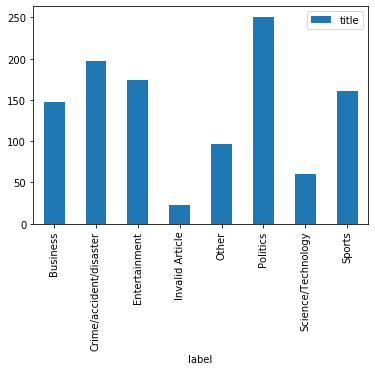

In [24]:
data_df.groupby('label').count()[['title']].plot(kind='bar')

Transfer Learning using BERT following example from https://explosion.ai/blog/spacy-transformers

In [25]:
nlp = spacy.load("en_trf_bertbaseuncased_lg")
print(nlp.pipe_names) # ["sentencizer", "trf_wordpiecer", "trf_tok2vec"]
textcat = nlp.create_pipe("trf_textcat", config={"exclusive_classes": True})
for label in data_df.label.unique():
    textcat.add_label(label)
nlp.add_pipe(textcat)

['sentencizer', 'trf_wordpiecer', 'trf_tok2vec']


In [0]:
TRAIN_DATA = []
for url, row in data_df.iterrows():
  TRAIN_DATA.append((row.all_text, {'cats': { row['label']: 1.0 }}))

In [27]:
TRAIN_DATA[:10]

[("Krispy Kreme pumpkin spice doughnuts are available in .FacebookEmail Twitter Google+ LinkedIn Pinterest \n Krispy Kreme pumpkin spice doughnuts are available now. Here's where to get them in Phoenix \n Krispy Kreme's pumpkin spice donuts are available September 2 to 8 in metro Phoenix. Pumpkin lattes, cheesecake-filled and cake doughnuts on the menu. \n Post to Facebook \n Krispy Kreme pumpkin spice doughnuts are available now. Here's where to get them in Phoenix   Krispy Kreme's pumpkin spice donuts are available September 2 to 8 in metro Phoenix. Pumpkin lattes, cheesecake-filled and cake doughnuts on the menu.    Check out this story on azcentral.com: https://www.azcentral.com/story/entertainment/dining/2019/09/04/krispy-kreme-pumpkin-spice-doughnuts-available-metro-phoenix/2210709001/ \n CancelSend \n A link has been sent to your friend's email address. \n Posted! \n A link has been posted to your Facebook feed. \n Join the Conversation",
  {'cats': {'Entertainment': 1.0}}),
 ("

In [28]:
len(TRAIN_DATA)

1110

In [0]:
SAMPLE_TRAIN_DATA = TRAIN_DATA

In [0]:
optimizer = nlp.resume_training()
for i in range(10):
  random.shuffle(SAMPLE_TRAIN_DATA)
  losses = {}
  for batch in minibatch(SAMPLE_TRAIN_DATA, size=8):
    texts, cats = zip(*batch)
    nlp.update(texts, cats, sgd=optimizer, losses=losses)
  print(i, losses)

In [0]:
sample_doc = data_df.sample(n=1).iloc[0]
doc = nlp(sample_doc.cleaned_all_text)